In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# pip3 install torch torchvision torchaudio
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

## 1. Activation functions

### ReLU

Activation functions are crucial components of neural networks because they introduce non-linear behavior. Without them, a network composed of stacked linear transformations would still behave like a single linear model, limiting its ability to capture complex patterns in the data.

One of the most widely used activation functions today is the Rectified Linear Unit (ReLU), defined as

\begin{align}
ReLU(x) = \begin{cases}
               0               & x<0\\
               x               & x\geq 0\\ \end{cases}
\end{align}


**1.1 Find the derivative of the ReLU function, $R'(x)$. Carefully consider the two regions when $x<0$ and $x\geq0$.** <br>

---

*Your answer here:*  for $x<0: R'(x) = 0$ and for $x\geq 0: R'(x) = 1$

---
**1.2 We now want to implement the ReLU activation in code. Fill in the missing parts of the following class so that it computes both the activation and its derivative.**

In [2]:
class ReLU:
    @staticmethod
    def forward(x):
        return 0 if x < 0 else x

    @staticmethod
    def gradient(x):
        return 0 if x < 0 else 1


### Sigmoid

One of the classical choices is the sigmoid function, which smoothly squashes any real-valued input into the range (0,1). This property made it popular in the early days of neural networks, particularly for binary classification problems, since its output can be interpreted as a probability.

\begin{align}
S(z) = \frac{1}{1 + e^{-z}}.
\end{align}

**1.3 Find the derivative of the Sigmoid function, $S'(x)$.** <br>

---

*Your answer here:*  $S'(x) = (\frac{1}{1 + e^{-z}})' = \frac{e^{-z}}{(1 + e^{-z})^2} = S(z)(1 - S(z))$

---
**1.4 We now want to implement the Sigmoid activation in code. Fill in the missing parts of the following class so that it computes both the activation and its derivative.**

In [3]:
class Sigmoid:
    @staticmethod
    def forward(x):
        return 1 / (1 + torch.exp(-x))

    @staticmethod
    def gradient(x):
        s = Sigmoid.forward(x)
        return s * (1 - s)

**1.5 For both activations compute both their output and derivative values for the following range.**
- Hint: Use a **2 × 2 grid of subplots**.
- Hint: Label your axes, add **titles** for each subplot, and don’t forget **legends**.  

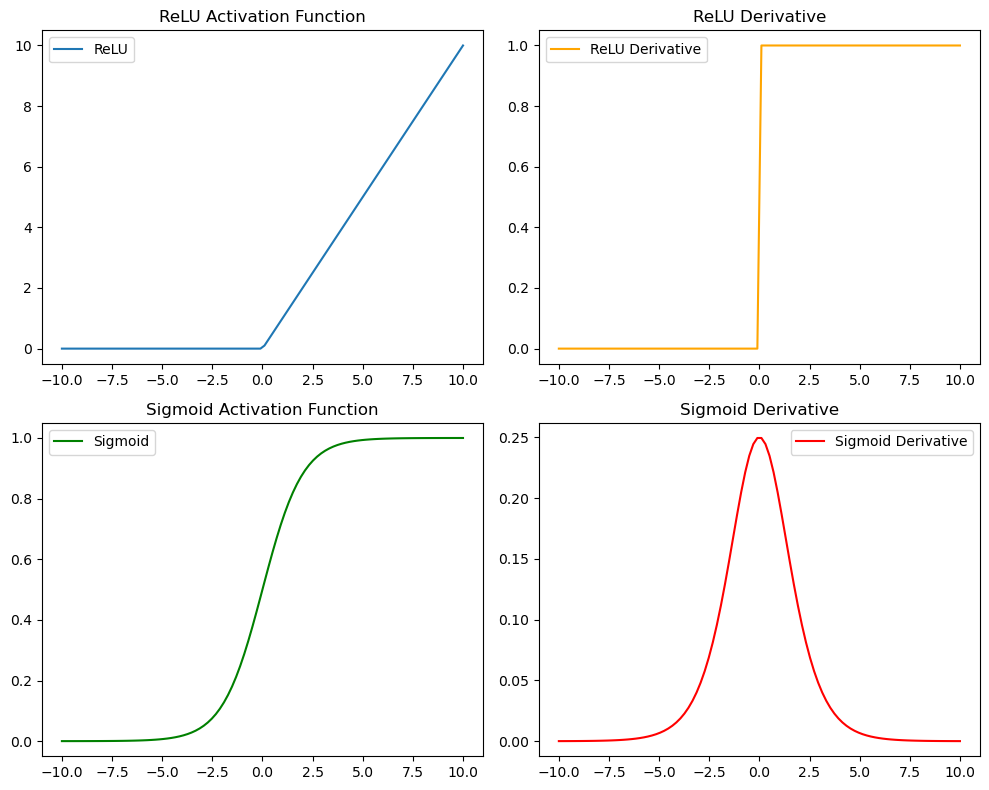

In [7]:
x = torch.linspace(-10, 10, 100)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# TODO: plot ReLU and Sigmoid functions and their derivatives
axs[0, 0].plot(x, [ReLU.forward(xi) for xi in x], label='ReLU')
axs[0, 0].set_title('ReLU Activation Function')
axs[0, 0].legend()

axs[0, 1].plot(x, [ReLU.gradient(xi) for xi in x], label='ReLU Derivative', color='orange')
axs[0, 1].set_title('ReLU Derivative')
axs[0, 1].legend()  

axs[1, 0].plot(x, [Sigmoid.forward(xi) for xi in x], label='Sigmoid', color='green')
axs[1, 0].set_title('Sigmoid Activation Function')  
axs[1, 0].legend()

axs[1, 1].plot(x, [Sigmoid.gradient(xi) for xi in x], label='Sigmoid Derivative', color='red')
axs[1, 1].set_title('Sigmoid Derivative')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## 2. The Perceptron

The **perceptron** is the simplest model of a neuron.  
Given an input vector $(x \in \mathbb{R}^d)$, it computes:

\begin{align}
y = \phi\!\left(\sum_{i=1}^{d} w_i x_i + b\right),
\end{align}

where  
- $(x_i)$ are the inputs,  
- $(w_i)$ are the corresponding weights,  
- $(b)$ is the bias term,  
- $(\phi(\cdot))$ is the activation function (e.g., sigmoid, ReLU, etc.).  

**2.1 Implement a `Perceptron` class with:**
   - a constructor that initializes weights and bias randomly,  
   - a `forward(x)` method that returns the activated output.

In [8]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # TODO: initialize weight matrix W and bias vector b
        self.W = torch.randn(1, input_dim)
        self.b = torch.randn(1)

    def forward(self, x):
        # TODO: compute z = w·x + b
        z = torch.matmul(self.W, x) + self.b
        # TODO: apply sigmoid activation
        a = torch.sigmoid(z)
        return a

**2.2 To verify your implementation recreate the Perceptron using Pytorch's built-in `torch.nn` modules and check that they behave in the same way**

PyTorch already provides layers for you:

- Look at `torch.nn.Linear` for the weight + bias computation.
- Don’t forget to apply an activation function afterwards — check out modules in `torch.nn`.
- You can combine them in sequence using `nn.Sequential`.

In [ ]:
# Create both layers
in_features, out_features = 3, 1
my_layer = Perceptron(in_features)
TorchPerceptron = nn.Sequential(
    nn.Linear(in_features, out_features),
    nn.Sigmoid()
)

# Copy parameters from your layer to torch.nn.Linear
with torch.no_grad():
    TorchPerceptron[0].weight.copy_(my_layer.W)
    TorchPerceptron[0].bias.copy_(my_layer.b)

# Test input
x = torch.rand(in_features)

# Forward pass
# TODO: compute outputs from both layers
my_output = my_layer(x)
torch_output = TorchPerceptron(x)

print("Difference:", torch_output - my_output) # should be sclose to zero

Difference: tensor([0.], grad_fn=<SubBackward0>)


## 3. The Linear Layer

A perceptron takes one input vector and produces a single output after applying a weighted sum, a bias, and an activation.  

A **linear layer** is simply a collection of multiple perceptrons stacked together.  
- Instead of one weight vector $(w)$, we now have a weight matrix $(W \in \mathbb{R}^{m \times d})$.  
- Each row of $(W)$ corresponds to the weights of one perceptron.  
- The bias term becomes a vector $(b \in \mathbb{R}^m)$.  
- The output is a vector $(y \in \mathbb{R}^m)$:  

\begin{align}
y &= W x + b
\end{align}

where  
- $x$ is the input of dimension $d$,  
- $W$ applies $m$ linear combinations of the inputs,  
- $b$ shifts (translates) the result.

This is often called an **affine transformation**: a linear transformation plus a translation.

**3.1 Fill the following code to implement your own Linear Layer class.**

In [10]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # TODO: initialize weight matrix W and bias vector b
        self.W = torch.randn(out_features, in_features)
        self.b = torch.randn(out_features)

    def forward(self, x):
        # TODO: implement y = Wx + b
        y = torch.matmul(self.W, x) + self.b
        return y

**3.2 To verify your implementation recreate the Linear Layer using Pytorch's built-in `torch.nn` modules and check that they behave in the same way**

In [ ]:
# Create both layers
in_features, out_features = 3, 2
my_layer = Linear(in_features, out_features)
TorchLinearLayer = nn.Linear(in_features, out_features)

# Copy parameters from your layer to torch.nn.Linear
with torch.no_grad():
    TorchLinearLayer.weight.copy_(my_layer.W)
    TorchLinearLayer.bias.copy_(my_layer.b)

# Test input
x = torch.rand(in_features)

# Forward pass
my_output = my_layer(x)
torch_output = TorchLinearLayer(x)

print("Difference:", torch_output - my_output) # Also close to zero

Difference: tensor([0., 0.], grad_fn=<SubBackward0>)


## 4. Multi-Layer Perceptron (MLP)
So far, you built:
- a Perceptron → single linear unit + nonlinearity
- a Linear layer → general affine transformation (x @ W^T + b)

These are the *building blocks* of neural networks.

A **Multi-Layer Perceptron (MLP)** is simply a stack of perceptrons (linear layers with nonlinearities between them).

- The first layer transforms the input into a hidden representation.
- A nonlinear activation (e.g., ReLU, Sigmoid, Tanh) makes the model expressive.
- The next layer(s) take the hidden representation and produce outputs.

\begin{align}
\mathbf{a}_{l} &= {\mathbf{W}}_{l}^T \mathbf{x}_{l-1} + \mathbf{b}_{l}\;. \\
\end{align}

Followed by the nonlinear activation 
\begin{align}
\mathbf{x}_{l} &= f_{l}(\mathbf{a}_{l})
\end{align}

where:
- $f_l$; Activation function for layer $l$
- $x_l$: The output of layer $l$.
- ${\mathbf{W}}_{l}$ Weights of layer $l$.
- $\mathbf{b}_{l}$ Bias of layer $l$.

**4.1 Fill the following code to implement your own MLP class.**

In [24]:
import torch
import torch.nn.functional as F

class MyMLP(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        # Initialize weights and biases
        self.W1 = torch.randn(H, D_in)
        self.b1 = torch.randn(H)
        self.W2 = torch.randn(D_out, H)
        self.b2 = torch.randn(D_out)

    def forward(self, x):
        # Handle both single inputs and batched inputs using proper broadcasting
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Add batch dimension (N, D_in)
        
        # First layer: (N, D_in) @ (D_in, H)^T -> (N, H)
        x1 = torch.matmul(x, self.W1.t()) + self.b1
        x1 = torch.relu(x1)
        
        # Second layer: (N, H) @ (H, D_out)^T -> (N, D_out)
        x2 = torch.matmul(x1, self.W2.t()) + self.b2
        out = torch.relu(x2)
        
        # Remove batch dimension for single inputs
        if out.shape[0] == 1:
            out = out.squeeze(0)
            
        return out

**4.2 To verify your implementation recreate the MLP using Pytorch's built-in `torch.nn` modules and check that they behave in the same way**

In [25]:
torch.manual_seed(0)
D_in, H, D_out = 3, 4, 1

manual = MyMLP(D_in, H, D_out)
TorchMLP = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
    nn.ReLU()
)

# TODO: Copy weights so forward passes should match exactly
with torch.no_grad():
    TorchMLP[0].weight.copy_(manual.W1)
    TorchMLP[0].bias.copy_(manual.b1)
    TorchMLP[2].weight.copy_(manual.W2)
    TorchMLP[2].bias.copy_(manual.b2)


# Single example
x1 = torch.tensor([0.5, -1.0, 2.0])
y_manual_1 = manual(x1)
y_nn_1 = TorchMLP(x1)
print("single:", torch.allclose(y_manual_1, y_nn_1, atol=1e-7), y_manual_1, y_nn_1)

# Test input
xB = torch.randn(5, D_in)

# Forward pass
y_manual_B = manual(xB)
y_nn_B = TorchMLP(xB)

print("All close:", torch.allclose(y_manual_B, y_nn_B, atol=1e-7))

single: True tensor([0.]) tensor([0.], grad_fn=<ReluBackward0>)
All close: True


## 5. Mean Squared Error (MSE) Loss

The Mean Squared Error (MSE) measures how far predictions are from the true values by averaging the squared differences.

For $N$ predictions $\hat{y}_i$ and true labels $y_i$:

\begin{align}
\mathcal{L}_{\text{MSE}} &= \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2
\end{align}

**5.1 Find the derivative of the MSE function** <br>

---

*Your answer here:*  $\mathcal{L}_{\text{MSE}}' = \frac{1}{N} \sum_{i=1}^N 2(\hat{y}_i - y_i) = \frac{2}{N} \sum_{i=1}^N (\hat{y}_i - y_i)$

---
**5.2 We now want to implement the MSE Loss in code. Fill in the missing parts of the following class so that it computes both the activation and its derivative.**

In [26]:
class MSE:
    @staticmethod
    def loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        return torch.mean((y_true - y_pred) ** 2)

    @staticmethod
    def gradient(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        return 2 * (y_pred - y_true) / y_true.numel()

**5.3 Compare against PyTorch’s built-in implementation. You can use `torch.nn.MSELoss` to compute the loss and gradients automatically.**

In [30]:
N, C = 5, 3
y_true = torch.rand(N, C)                      
y_pred = torch.rand(N, C, requires_grad=True)  

# --- Built-in PyTorch loss ---
torch_loss = torch.nn.MSELoss()(y_true, y_pred)

# Backprop to get gradients
torch_loss.backward()
torch_grad = y_pred.grad.clone()

# --- Your implementation ---
manual_loss = MSE.loss(y_true, y_pred)
manual_grad = MSE.gradient(y_true, y_pred)

# --- Compare ---
print("PyTorch loss:", torch_loss.item())
print("Manual loss:", manual_loss.item())

print("\nPyTorch gradient:\n", torch_grad)
print("Manual gradient:\n", manual_grad)

print("\nLoss close?  ", torch.allclose(torch_loss, manual_loss))
print("Grad close?  ", torch.allclose(torch_grad, manual_grad))

PyTorch loss: 0.13756482303142548
Manual loss: 0.13756482303142548

PyTorch gradient:
 tensor([[-0.0583, -0.0335, -0.0207],
        [ 0.0590, -0.0364,  0.0092],
        [-0.0748, -0.0063, -0.0696],
        [ 0.1033,  0.0211,  0.0554],
        [ 0.0362,  0.0257, -0.0144]])
Manual gradient:
 tensor([[-0.0583, -0.0335, -0.0207],
        [ 0.0590, -0.0364,  0.0092],
        [-0.0748, -0.0063, -0.0696],
        [ 0.1033,  0.0211,  0.0554],
        [ 0.0362,  0.0257, -0.0144]], grad_fn=<DivBackward0>)

Loss close?   True
Grad close?   True


## 6. The whole Pipeline: Training on FashionMNIST

### Loading the FashionMNIST Dataset

We will use **FashionMNIST**, a dataset of grayscale 28×28 images of clothing items (e.g., shirts, shoes, bags).  
It is built into PyTorch and can be easily downloaded.

#### Datasets and Dataloaders
- A **Dataset** object (like `datasets.FashionMNIST`) gives you access to the data samples and their labels.  
- A **DataLoader** wraps a dataset and helps you:
  - Load the data in **mini-batches** (instead of one sample at a time).  
  - **Shuffle** the data during training (good for generalization).  
  - Use multiple worker processes to speed up loading.  

In practice, you almost always combine a Dataset with a DataLoader when training models in PyTorch.


100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%
0.7%

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



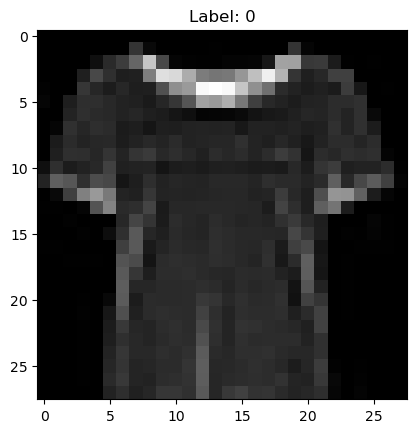

In [31]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Setup the Dataloader for training
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

**6.1 How many features does each sample have?**

**6.2 How many classes do we have in the dataset?**

---

*Your answers here:*  

---

### Choosing a Device (CPU or GPU)

Training deep learning models can be much faster on a GPU, if one is available.  
In PyTorch, we usually set a `device` variable so that both the model and the data can be placed consistently on either:

- **GPU (`"cuda"`)** → preferred for faster training when available  
- **CPU (`"cpu"`)** → always available, sufficient for small exercises  

For this exercise, using a GPU is **not required** — but it’s good practice to write code that supports both.


In [32]:
# Select GPU if available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


### Defining a Neural Network in PyTorch

We now define a simple **feedforward neural network** for image classification.

- **`nn.Flatten()`** → converts a 2D image (28×28 pixels) into a 1D tensor (length 784).  
- **`nn.Sequential()`** → a container that runs layers in order. Here it includes:  
  1. A linear (fully connected) layer mapping from `28*28` inputs to a hidden dimension.  
  2. A **ReLU** activation function for nonlinearity.  
  3. Another linear layer mapping from the hidden dimension to 10 output classes.

The network returns **logits** (unnormalized scores for each class).


In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# Initialize the model with the appropriate arguments based on our dataset and move it to the device.
# Hint: For hidden features you can use 128
model = NeuralNetwork(28*28, 128, 10).to(device)

# Display the model architecture
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Hyperparameters, Loss Function, and Optimizer

To train our neural network, we need to set a few key choices:

- **Learning rate**: controls how big each parameter update step is.  
- **Batch size**: number of samples processed together before updating weights.  
- **Epochs**: how many full passes we make over the training dataset.  

We also need:

- **Loss function**: measures how far the model’s predictions are from the true labels.  
  - Here we use **Cross-Entropy Loss**, the standard choice for multi-class classification.  
- **Optimizer**: updates model parameters using the gradients.  
  - Here we use **Stochastic Gradient Descent (SGD)** with the chosen learning rate.


In [34]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

# Loss function (for classification)
loss_fn = nn.CrossEntropyLoss()

# Optimizer (SGD with given learning rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training and Evaluating a Neural Network

Once we have a dataset and a model, the next step is to **train** the model so that it can make accurate predictions.

### Training
Training is the process of teaching the model to minimize a **loss function** by adjusting its parameters (weights and biases).  
This is done using an algorithm called **backpropagation** combined with an **optimizer** (such as SGD or Adam).
We will be looking closer at backpropagation in the next sessions.

The training loop typically consists of:
1. **Forward pass** → feed the input through the model to get predictions.  
2. **Compute the loss** → measure how far predictions are from the true labels.  
3. **Backward pass** → compute gradients of the loss with respect to model parameters.  
4. **Update parameters** → use the optimizer to adjust weights and biases.  

Repeating this process over the dataset (for multiple **epochs**) gradually improves the model.

### Evaluation
After training, we need to evaluate the model on **unseen data** (the test set).  
During evaluation:
- We disable gradient calculations (`torch.no_grad()`), since we are not training.  
- The model is set to **evaluation mode** (`model.eval()`), which is important for certain layers (e.g., dropout, batch normalization).  
- We measure **accuracy** and **average loss** to understand how well the model generalizes.


**6.3 Complete the training loop and train the model for 10 epochs.**

In [ ]:
def train(dataloader, model, loss_fn, optimizer, losses=[]):
    model.train()  # set model to training mode
    
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        # TODO: perform the forward pass 
        pred = model(X.to(device))
        y = y.to(device)

        # Compute the loss
        loss = loss_fn(pred, y)

        # Just for logging
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad() # 1. Reset gradients
        loss.backward()       # 2. Compute current gradients
        optimizer.step()      # 3. Update parameters

        if batch % 100 == 0:
            loss_val = loss.item()
            print(f"loss: {loss_val:>7f}")
    return losses

# training loop
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_losses = train(train_dataloader, model, loss_fn, optimizer, train_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 2.314652
loss: 2.255579
loss: 2.193370
loss: 2.172781
loss: 2.108022
loss: 2.034793
loss: 2.034346
loss: 1.942953
loss: 1.956524
loss: 1.845231
Epoch 2
-------------------------------
loss: 1.897163
loss: 1.853842
loss: 1.736875
loss: 1.762145
loss: 1.622761
loss: 1.598424
loss: 1.601212
loss: 1.508181
loss: 1.555428
loss: 1.428490
Epoch 3
-------------------------------
loss: 1.532212
loss: 1.496961
loss: 1.353105
loss: 1.424514
loss: 1.280576
loss: 1.298656
loss: 1.306886
loss: 1.235498
loss: 1.292842
loss: 1.179116
Epoch 4
-------------------------------
loss: 1.289847
loss: 1.278390
loss: 1.114737
loss: 1.225155
loss: 1.079622
loss: 1.115718
loss: 1.138410
loss: 1.076215
loss: 1.136495
loss: 1.040027
Epoch 5
-------------------------------
loss: 1.135125
loss: 1.147176
loss: 0.964739
loss: 1.105282
loss: 0.960958
loss: 0.999892
loss: 1.036255
loss: 0.977271
loss: 1.037063
loss: 0.954421
Epoch 6
-------------------------------
loss: 1.03

**6.4 Define a function to evaluate the model on the test dataset.**

In [38]:

def test(dataloader, model, loss_fn):
    """
    TODO:  Evaluate the model on the test dataset and return the accuracy and average loss.
    """
    model.eval()  # set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0   
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

accuracy, loss = test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.772946 



### Saving and Loading Models in PyTorch

After training a neural network, it’s important to save the learned parameters so we can reuse the model later without retraining from scratch.

In PyTorch, we typically save the **state dictionary** (`state_dict`) of the model, which contains all trainable parameters (weights and biases).  

```python
torch.save(model.state_dict(), "model_weights.pth")
```

To reuse a saved model:

1. Recreate the model architecture.
2. Load the saved state dictionary into it.
3. Evaluate or continue training as needed.

This way, the new model has the same parameters as the trained one.

In [40]:
# Save the trained model's parameters
torch.save(model.state_dict(), "model_weights.pth")


# Create a new instance of the model (untrained) and load the saved parameters
model_new = NeuralNetwork(28*28, 128, 10)
model_new.load_state_dict(torch.load("model_weights.pth"))
test(test_dataloader, model_new, loss_fn)

C:\Users\au700932\AppData\Local\Temp\ipykernel_19528\410667921.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load("model_weights.pth"))

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.772946 



(0.7219, 0.7729464964881824)

## 7. MCQ

---

## 7.1 Activation Functions
Which of the following is the main purpose of using an activation function in a neural network?  

A. To increase the number of layers in the network  
B. To introduce non-linearity so the network can model complex functions  
C. To normalize the input data before training  
D. To reduce overfitting during training  

**Answer:**  B

---

## 7.2. The Perceptron
A single perceptron can only represent:  

A. Any continuous function  
B. Non-linear decision boundaries  
C. Linear decision boundaries  
D. Polynomial functions  

**Answer:** C

---

## 7.3. Linear Layer
In a linear (fully connected) layer with input dimension $d$ and output dimension $m$, the weight matrix $W$ has the shape:  

A. $(d \times m)$  
B. $(m \times d)$  
C. $(d \times d)$  
D. $(m \times m)$  

**Answer:**  In the case of $W^Tx+b$ the answer is A, otherwise B for $Wx+b$.

---

## 7.4. Loss Functions
The Mean Squared Error (MSE) loss between predictions $\hat{y}$ and targets $y$ is defined as:  

A. $\frac{1}{N}\sum_{i=1}^N |\hat{y}_i - y_i|$  
B. $\frac{1}{N}\sum_{i=1}^N (\hat{y}_i - y_i)^2$  
C. $\sum_{i=1}^N (\hat{y}_i - y_i)$  
D. $\max(\hat{y}_i, y_i)$  

**Answer:** B

---

## 7.5. Multi-Layer Perceptron (MLP)
Compared to a single perceptron, a multi-layer perceptron can:  

A. Only model linear functions  
B. Model more complex, non-linear functions  
C. Avoid the need for activation functions  
D. Train without using backpropagation  

**Answer:** B

---

## 7.6. Training Procedure
Which of the following is the correct order of steps in one training iteration?  

A. Backward pass → Forward pass → Update weights  
B. Forward pass → Compute loss → Backward pass → Update weights  
C. Update weights → Forward pass → Compute loss → Backward pass  
D. Forward pass → Update weights → Compute loss → Backward pass  

**Answer:**  B

---
